In [71]:
from matplotlib import pyplot as plt
import numpy as np
import polars as pl
from scipy import optimize, stats

import graph_importer as gim

In [2]:
tempo = gim.make_graph("./concordant_networks/temponet_14_365.lgl")

In [3]:
edge_df = pl.from_dicts(
        [
            {
                "source_time": edge.source_vertex["time"],
                "source_loc": edge.source_vertex["loc"],
                "dest_time": edge.target_vertex["time"],
                "dest_loc": edge.target_vertex["loc"],
                "weight": edge["weight"],
            }
            for edge in tempo.es
        ]
    ).lazy()

In [9]:
direct_threshold = 14

aug_edge_df = edge_df.with_columns(
        direct=((pl.col("dest_time") - pl.col("source_time") < direct_threshold)),
        link_time=(pl.col('dest_time') - pl.col('source_time'))
    )

In [28]:
lt_dist = (aug_edge_df
           .filter(pl.col('link_time') > 0)
           .group_by('source_loc', 'dest_loc', 'link_time')
           .agg(pl.col('weight').sum())
           .sort('link_time')
           .group_by('source_loc', 'dest_loc')
           .all()
           .collect()
          )

In [29]:
lt_dist

source_loc,dest_loc,link_time,weight
i64,i64,list[i64],list[f64]
511,8910,"[28, 42, … 364]","[2.0, 1.0, … 2.0]"
3140,5030,"[14, 28, … 140]","[1.0, 1.0, … 1.0]"
4931,9001,"[14, 28, … 364]","[13.0, 16.0, … 7.0]"
7052,8403,"[14, 42, … 364]","[3.0, 1.0, … 1.0]"
5347,2290,"[196, 238]","[1.0, 1.0]"
…,…,…,…
99,5111,"[112, 126, 266]","[1.0, 1.0, 1.0]"
4691,7122,"[14, 28, … 364]","[344.0, 248.0, … 34.0]"
3863,6243,[294],[1.0]


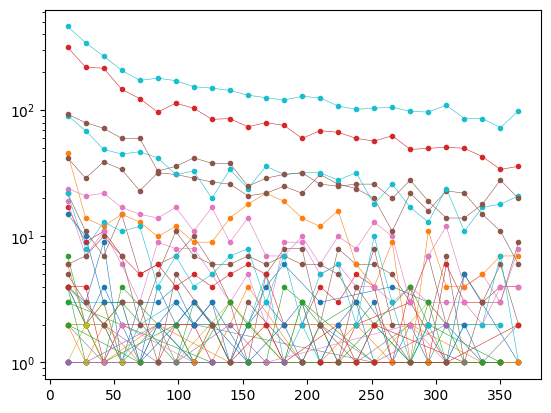

In [190]:
f = plt.figure()
ax = f.add_subplot()
ax.set_yscale('log')
# ax.set_xscale('log')

lt_sample = lt_dist.sample(100, seed=2024)

for ln in lt_sample.filter(pl.col('link_time').list.len() > 2).to_dicts():
    ww = np.array(ln['weight'])
    # ww /= np.sum(ww)
    ax.plot(ln['link_time'], ww, marker='.', lw=0.4)

In [38]:
lt_sample.select(pl.col('source_loc', 'dest_loc'), pl.col('link_time').list.len()).sort('link_time')

source_loc,dest_loc,link_time
i64,i64,u32
9167,7422,1
7845,6232,1
2465,1898,1
322,8967,1
6810,6256,1
…,…,…
3805,9330,26
7133,2388,26
2398,9583,26


Text(0, 0.5, 'frequency')

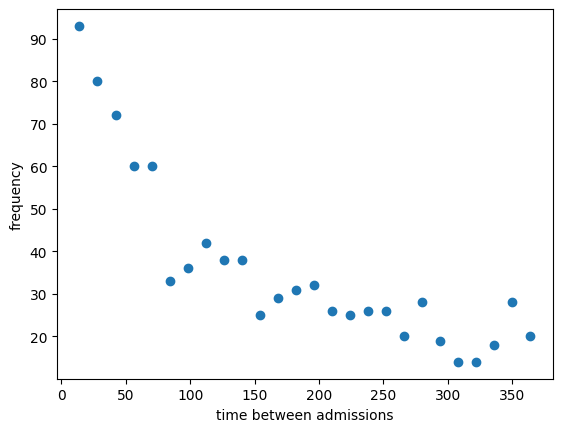

In [189]:
sample_sample = lt_sample.filter(pl.col('source_loc') == 2693).to_dicts()[0]
plt.plot(sample_sample['link_time'], sample_sample['weight'], 'o')
plt.xlabel('time between admissions')
plt.ylabel('frequency')

In [72]:
exp_model = lambda x, a, lam: a*np.exp(-lam*x)
pow_model = lambda x, a, p:  a*(x**p)
ls_res = lambda x, y, f, *ps: np.sum((y - f(x, *ps))**2)

In [110]:
_x = np.array(sample_sample['link_time'])
_y = np.array(sample_sample['weight'])
_a = 50
_lam = 0.01

In [113]:
fitted = lambda x, y, f, bounds, *ps: optimize.minimize(lambda px: ls_res(x, y, f, *px), x0=np.array(ps), 
                                                bounds=bounds)

In [170]:
exp_bounds = [(None, None), (0, None)]
pow_bounds = [(None, None), (None, None)]

In [171]:
feo = fitted(_x, _y, exp_model, exp_bounds, _a, _lam)
fpo = fitted(_x, _y, pow_model, pow_bounds, _a, 0.6)

In [163]:
def view_fit(x, y, f, ps, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    ax.plot(x, y, 'o')
    ax.plot(x, f(x, *ps))
    return ax

def residuals(x, y, f, ps):
    z = f(x, *ps)
    return (y-z)


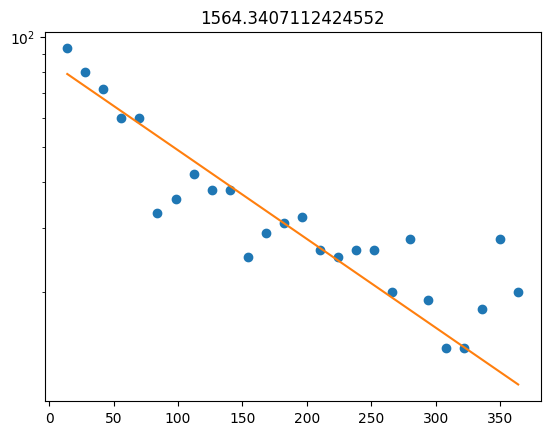

In [166]:
ax = view_fit(_x, _y, exp_model, feo.x)
plt.title(feo.fun)
# plt.xscale('log')
plt.yscale('log')

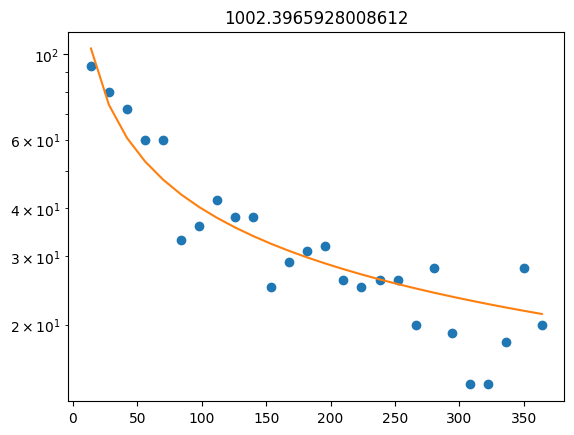

In [121]:
view_fit(_x, _y, pow_model, fpo.x)
plt.title(fpo.fun)
# plt.xscale('log')
plt.yscale('log')

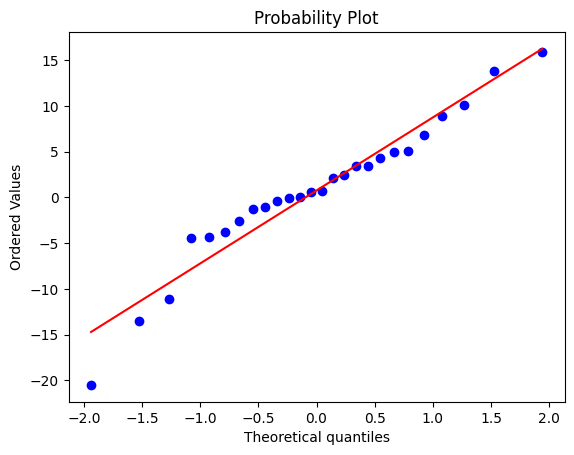

In [187]:
stats.probplot(residuals(_x, _y, exp_model, feo.x), plot=plt);

In [142]:
stats.shapiro(residuals(_x, _y, exp_model, feo.x)), stats.shapiro(residuals(_x, _y, pow_model, fpo.x))

(ShapiroResult(statistic=0.9549857378005981, pvalue=0.3024572432041168),
 ShapiroResult(statistic=0.973770260810852, pvalue=0.7222219705581665))

In [183]:
def normalityness(x, y,):
    _x = np.array(x)
    _y = np.array(y)
    fit = fitted(_x, _y, exp_model, exp_bounds, _a, 0.02)
    # print(fit)
    return stats.shapiro(
        residuals(_x, _y, exp_model, fit.x)
    )

In [184]:
normalityness(_x, _y,)

ShapiroResult(statistic=0.9549857974052429, pvalue=0.30245792865753174)

In [185]:
feo.x

array([8.56264087e+01, 5.60026336e-03])